# Fracture Leg Detection

### Project Overview

Fractures in the lower extremities, particularly the legs, are common injuries that require prompt diagnosis and treatment to ensure proper healing and prevent complications. Traditional methods of diagnosing fractures often rely on radiographic imaging, which can be time-consuming and may not be readily available in all settings. Leveraging advancements in deep learning and computer vision, this project aims to develop a robust system for detecting fractured legs from medical images using the VGG16 pre-trained convolutional neural network (CNN) architecture.

### Import Libraries

In [1]:
# Utilities
import os
import pandas as pd
import numpy as np

# Deep Learning
import cv2 
import tensorflow as tf
import keras
from keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from keras.models import Model, load_model
from tensorflow.keras.optimizers import SGD
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.metrics import Precision, Recall, AUC, TruePositives, TrueNegatives, TrueNegatives, FalsePositives, FalseNegatives
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Visualization
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

### Build Model from Pretrained Model

In [2]:
base_model = VGG16(input_shape = (256, 256, 3), include_top = False)

In [3]:
for layer in base_model.layers:
  layer.trainable = False

In [4]:
x = base_model.output
x = base_model.output
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)  # Reduced dropout rate
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)  # Reduced dropout rate
output = Dense(2, activation='sigmoid')(x)

This architecture builds upon the VGG16 base model by adding additional layers for further feature extraction and classification. The base_model.output serves as the input for these additional layers. After passing through a convolutional layer with 64 filters and a ReLU activation function, followed by max-pooling, the feature maps are further processed by another convolutional layer with 128 filters and max-pooling. This pattern continues with a convolutional layer with 256 filters and max-pooling. Subsequently, a global average pooling layer is applied to reduce spatial dimensions, followed by fully connected layers with 512 and 256 neurons, respectively, each activated by ReLU. Batch normalization is applied to stabilize and accelerate the training process, followed by dropout layers with a dropout rate of 0.4 to prevent overfitting. Finally, the output layer consists of a dense layer with 2 neurons and a sigmoid activation function, suitable for binary classification tasks. This architecture combines the feature extraction capabilities of VGG16 with additional layers for improved classification performance and regularization.

In [5]:
model = Model(base_model.input, output)

In [6]:
optimizer = SGD(
    learning_rate=0.01,
    decay=1e-6,
    momentum=0.9,
    nesterov=True
)

metrics = [
    'accuracy',
    Precision(),
    Recall(),
    AUC(),
    TruePositives(),
    TrueNegatives(),
    FalsePositives(),
    FalseNegatives()
]

model.compile(
    optimizer=optimizer,
    loss=keras.losses.binary_crossentropy,
    metrics=metrics
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 256, 256, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 128, 128, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 32, 32, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 8, 8, 64)            │         294,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 15,645,186 (59.68 MB)

 Trainable params: 928,962 (3.54 MB)

 Non-trainable params: 14,716,224 (56.14 MB)

### Image Data Generator

This code configures an ImageDataGenerator for data augmentation and sets up training and validation data generators using the specified parameters. The ImageDataGenerator applies various transformations to the input images, including rotation, shifting, shearing, zooming, flipping, and brightness adjustment, to create augmented training samples. These transformations help increase the diversity of the training data and improve the model's ability to generalize to unseen examples. The flow_from_directory function then loads the training and validation data from the specified directory, resizes the images to a consistent size of 256x256 pixels, and organizes them into batches of 32 images. The training data generator is configured to use 90% of the data for training, while the remaining 10% is used for validation. The labels are encoded in categorical format, enabling the model to perform multi-class classification. Overall, this setup facilitates efficient training of deep learning models with augmented image data.

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1/255,
    validation_split=0.1,
    featurewise_center=True,
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.5, 1.5],
    preprocessing_function=preprocess_input
)

train_data = train_datagen.flow_from_directory(
    batch_size=32,
    directory="./dataset/train",
    shuffle=True,
    target_size=(256, 256),
    subset="training",
    class_mode='categorical'
)

validation_data = train_datagen.flow_from_directory(
    batch_size=32,
    directory="./dataset/train",
    shuffle=True,
    target_size=(256, 256),
    subset="validation",
    class_mode='categorical'
)

Found 128 images belonging to 2 classes.
Found 14 images belonging to 2 classes.


In [8]:
for t_img, label in train_data:
    print("Processing batch...")
    print("Shape of training image batch:", t_img.shape)
    print("Shape of training label batch:", label.shape)
    
    break

Processing batch...
Shape of training image batch: (32, 256, 256, 3)
Shape of training label batch: (32, 2)


In [9]:
def plotImages(img_arr, label):
    num_images = len(img_arr)
    num_rows = 6
    num_cols = 8
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 15))  # Adjust rows and columns as needed

    for idx, ax in enumerate(axes.flat):
        if idx < num_images:
            ax.imshow(img_arr[idx])
            ax.set_title(label[idx])
            ax.axis('off')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

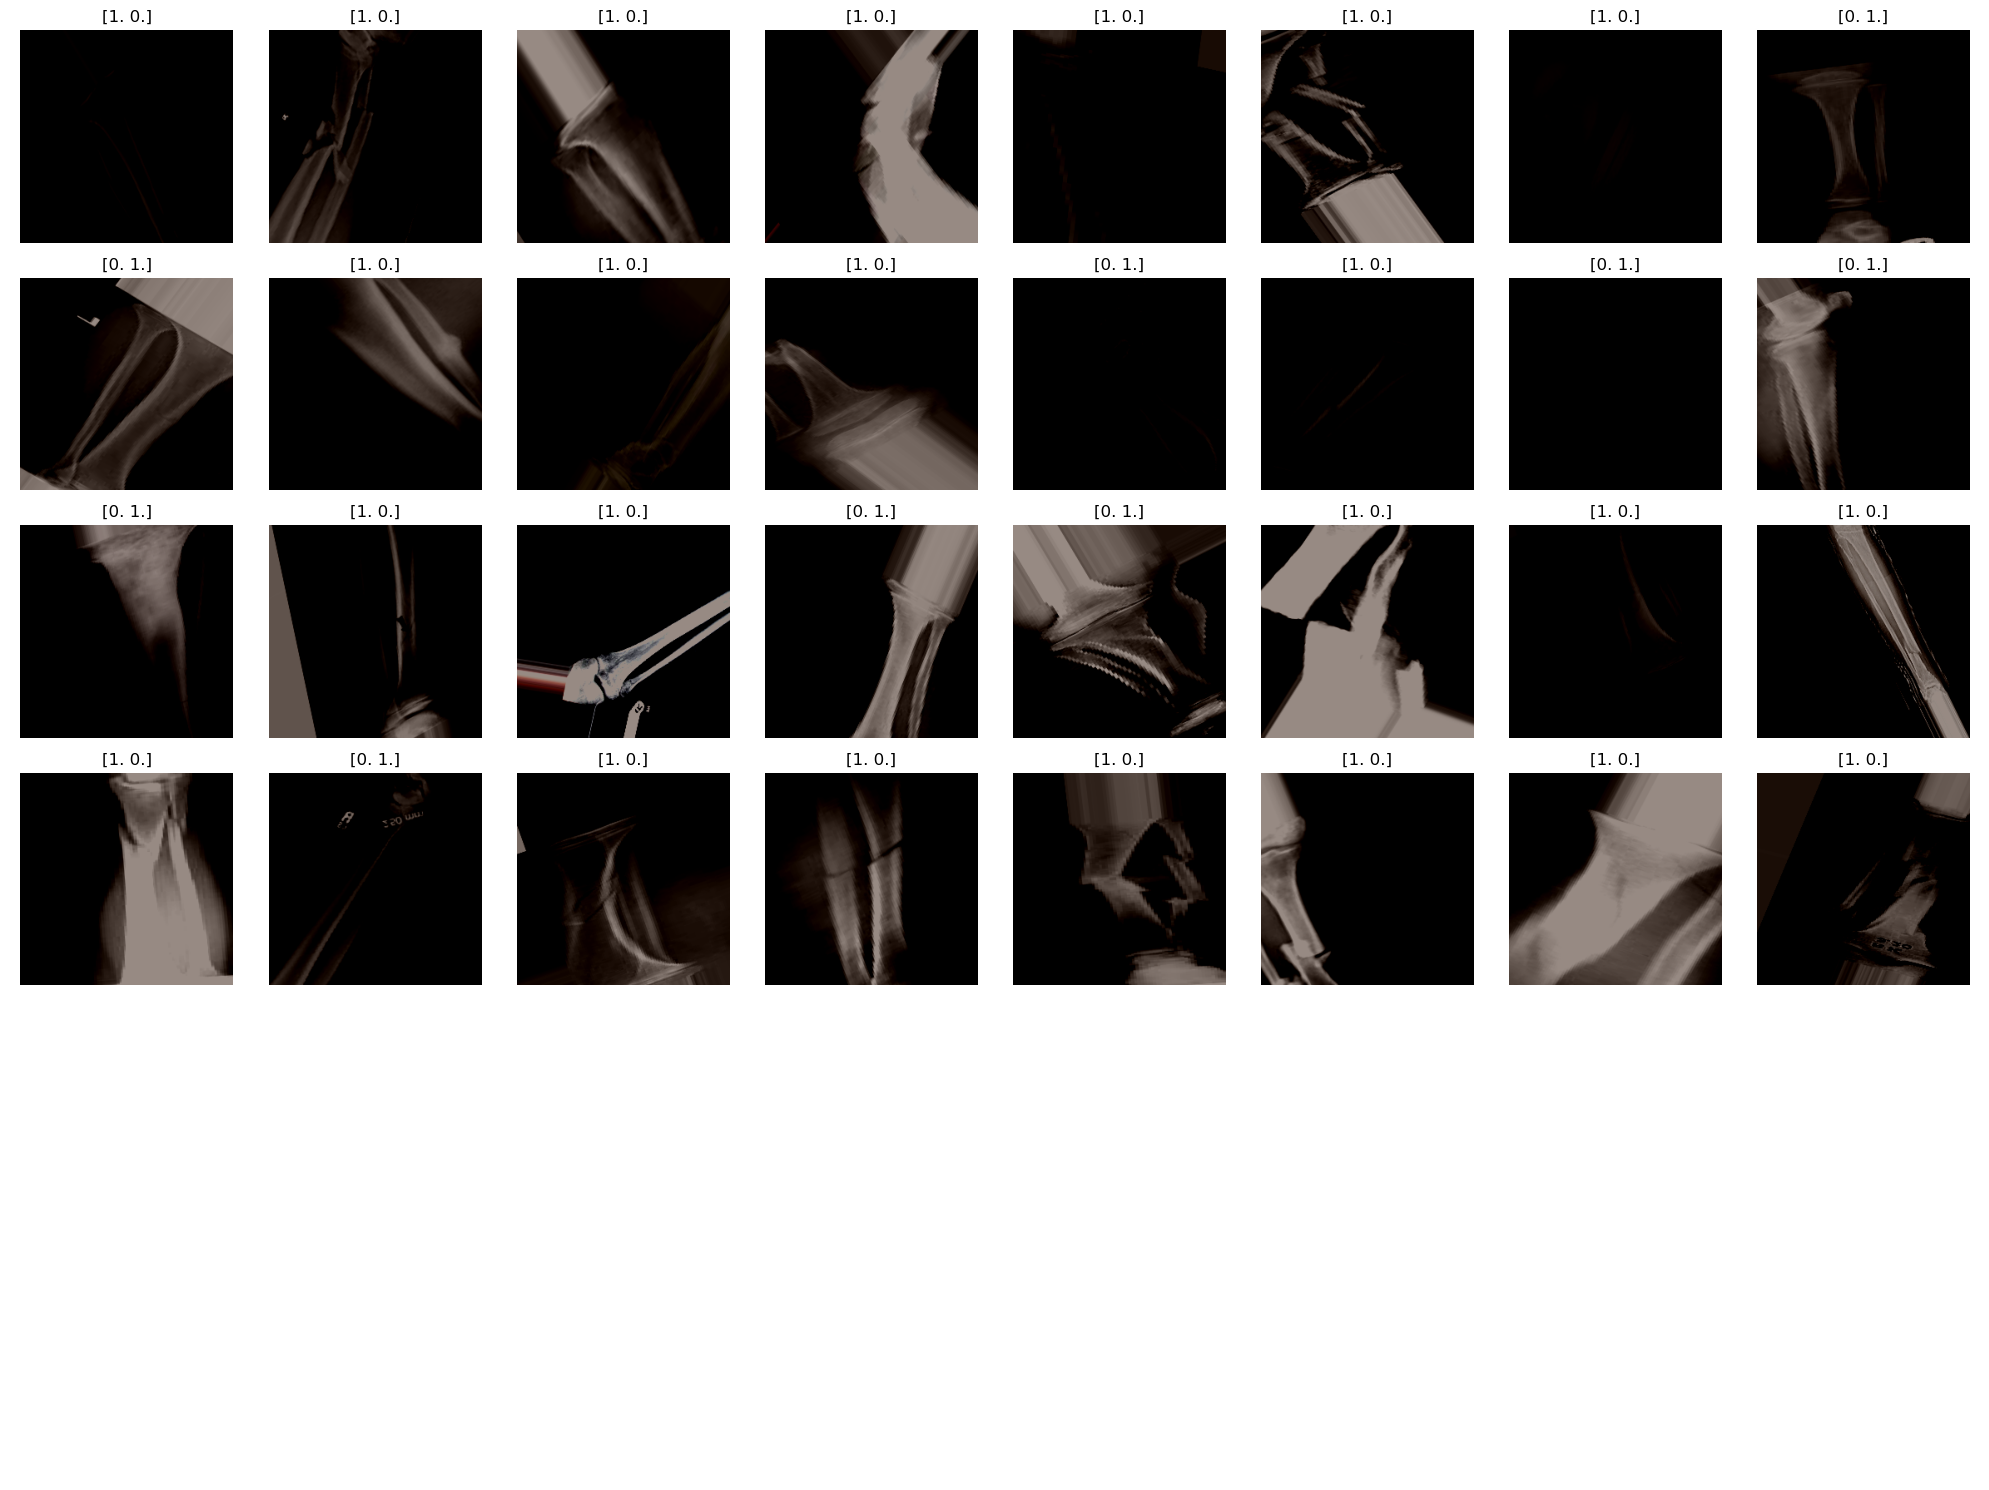

In [10]:
plotImages(t_img, label)

### Training The Model

In [11]:
model_checkpoint = ModelCheckpoint(filepath="./best_model.keras", 
                                   monitor='accuracy', 
                                   verbose=1,
                                   save_best_only=True)

early_stopping = EarlyStopping(monitor='accuracy',  
                               min_delta=0.001, 
                               patience=100, 
                               verbose=1)

callbacks = [model_checkpoint, early_stopping]

history = model.fit(train_data, 
                    steps_per_epoch=1,
                    epochs=500, 
                    callbacks=callbacks, 
                    validation_data=validation_data)

Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.5000 - auc: 0.4712 - false_negatives: 16.0000 - false_positives: 17.0000 - loss: 1.0549 - precision: 0.4848 - recall: 0.5000 - true_negatives: 15.0000 - true_positives: 16.0000
Epoch 1: accuracy improved from -inf to 0.50000, saving model to ./best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step - accuracy: 0.5000 - auc: 0.4712 - false_negatives: 16.0000 - false_positives: 17.0000 - loss: 1.0549 - precision: 0.4848 - recall: 0.5000 - true_negatives: 15.0000 - true_positives: 16.0000 - val_accuracy: 0.5714 - val_auc: 0.5638 - val_false_negatives: 0.0000e+00 - val_false_positives: 14.0000 - val_loss: 0.7017 - val_precision: 0.5000 - val_recall: 1.0000 - val_true_negatives: 0.0000e+00 - val_true_positives: 14.0000
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6562 - auc: 0.6514 - false_negatives: 10.0000 - false_positives: 13.0000 - loss: 0.8522 - precision: 0.6286 - recall: 0.6875 - true_negatives: 19.0000 -

### Testing and Evaluation

In [12]:
model =  load_model("./best_model.keras")

In [13]:
h = history.history

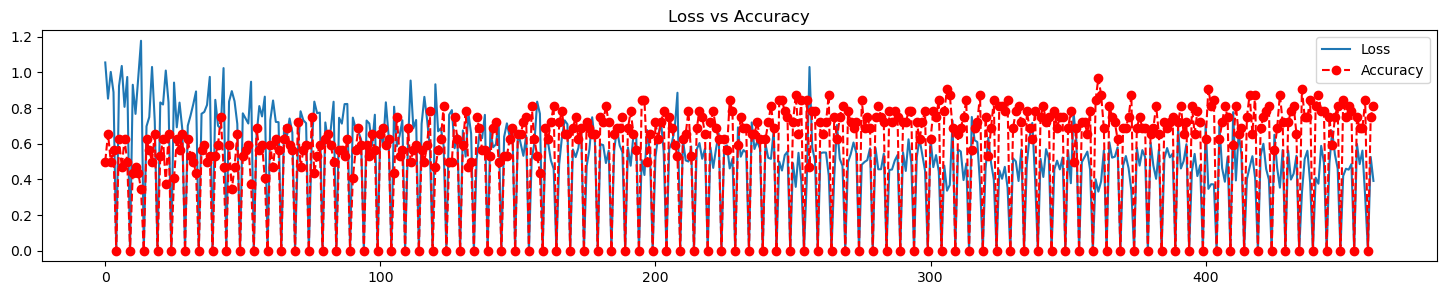

In [14]:
# Set figure size with wider width and shorter height
plt.figure(figsize=(18, 3))

# Plotting loss
plt.plot(h['loss'], label='Loss')

# Plotting accuracy with green circles
plt.plot(h['accuracy'], 'go--', label='Accuracy', color="red")

# Setting title
plt.title("Loss vs Accuracy")

# Adding legend
plt.legend()

# Displaying the plot
plt.show()


Based on the provided loss and accuracy history, it appears that the model is indeed learning, albeit with some fluctuations. Here's a more detailed analysis:

* Loss Trend: The loss generally decreases over time, which indicates that the model is improving in terms of its ability to minimize errors. However, there are occasional spikes in the loss values, suggesting that the model encounters some challenges during training. These spikes might occur due to various reasons such as noisy data, model complexity, or insufficient training data. Overall, the decreasing trend indicates that the model is learning to better fit the training data.

* Accuracy Trend: The accuracy values also show a general increasing trend over epochs. This indicates that the model's performance in predicting the correct output is improving over time. However, like the loss values, there are fluctuations in accuracy, suggesting that the model's performance varies during training. These fluctuations might occur due to changes in the model's ability to generalize to unseen data or due to the inherent randomness in the training process.

* Learning Stability: Although there are fluctuations in both loss and accuracy values, the overall trend indicates that the model is learning. It's essential to monitor both loss and accuracy to ensure that the model is not only minimizing errors but also making correct predictions. Additionally, the fact that both loss and accuracy exhibit trends over epochs suggests that the model is not stuck in local minima or maxima but rather making progress in optimizing its parameters.

In summary, while there are fluctuations in the loss and accuracy values, the overall trend indicates that the model is learning and improving its performance over time. However, further analysis, such as evaluating the model on validation or test data, would be necessary to assess its generalization ability and ensure that it is not overfitting to the training data.

### Test Plot Prediction Image with Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


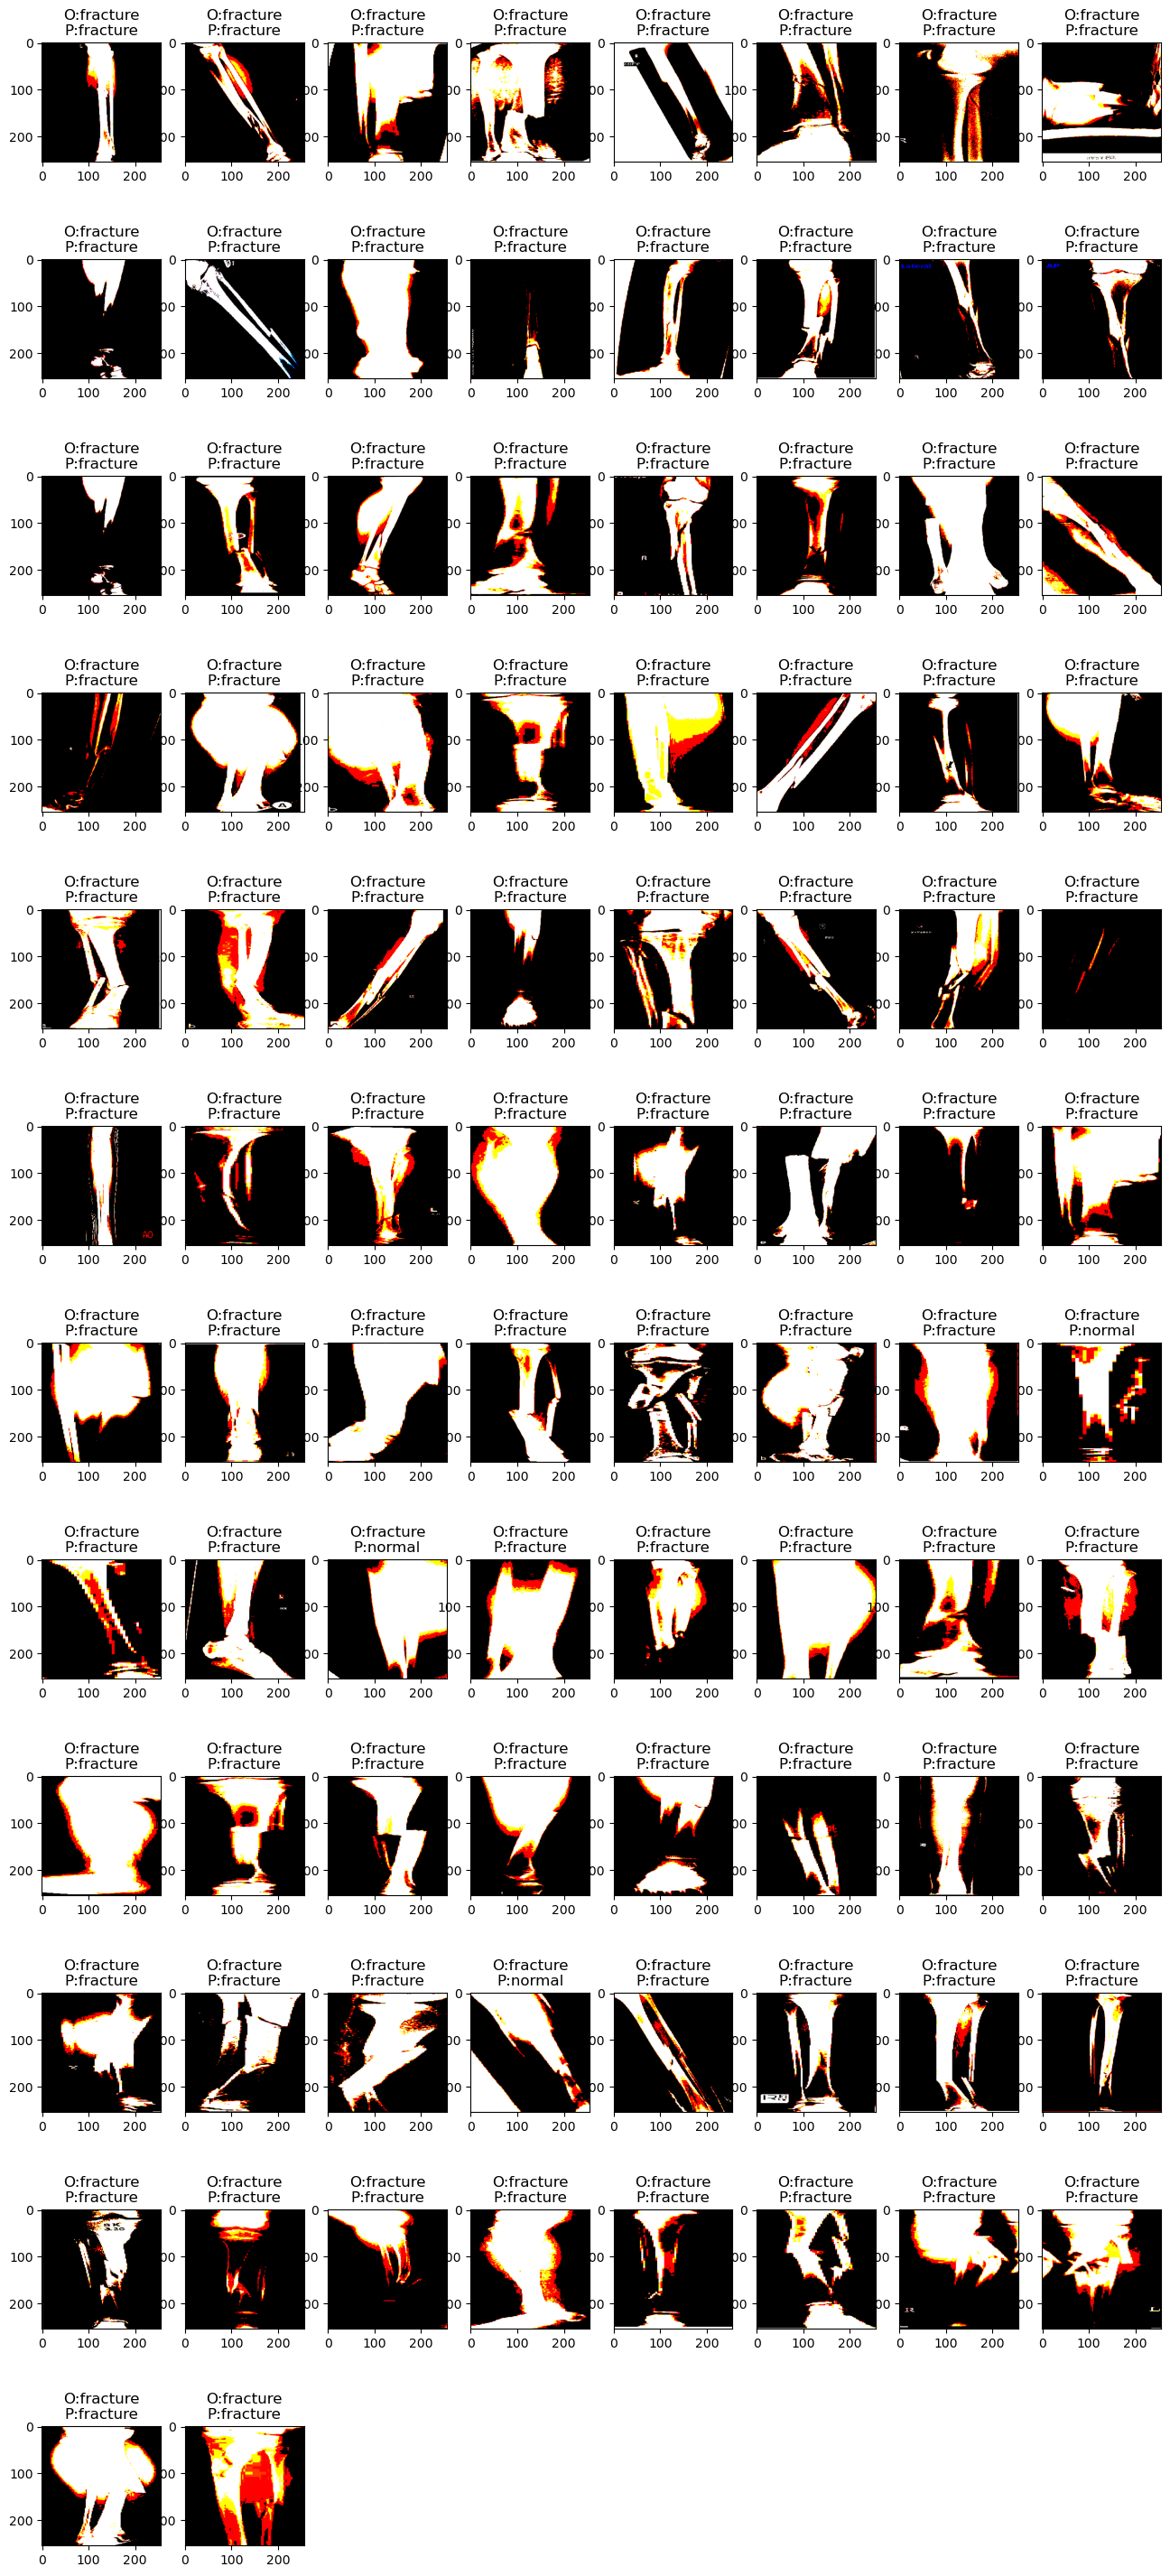

In [18]:
a = 13  # number of rows
b = 8  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize=(16,40))

for item in (os.listdir("./dataset/train/fracture/")):
    plt.subplot(a, b, c)
    path = "./dataset/train/fracture/" + item
    img = load_img(path, target_size=(256, 256))

    i = img_to_array(img)
    i = preprocess_input(i)
    input_arr = np.array([i])
    input_arr.shape

    pred = np.argmax(model.predict(input_arr))

    if pred == 0:
      item1 = "O:" + "fracture\n" + "P:fracture"
    else:
      item1 = "O:" + "fracture\n" + "P:normal"

    plt.imshow(input_arr[0])
    plt.title(item1)
    plt.axis = False
    c = c + 1

plt.show()